In [1]:
#!/usr/bin/env python
# coding: utf-8
# (c) Charles Le Losq, Clément Ferraina 2023
# see embedded licence file
# iVisc 1.0

#
# Library Loading
#
import pandas as pd # manipulate dataframes
import matplotlib.pyplot as plt # plotting
import numpy as np
np.random.seed = 167 # fix random seed for reproducibility

import time, os

# local imports
import src.utils as utils
import src.ivisc as ivisc

# import sklearn models
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor as KNR
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.metrics.pairwise import polynomial_kernel
from sklearn.metrics.pairwise import sigmoid_kernel
from sklearn.metrics.pairwise import rbf_kernel
from sklearn. preprocessing import StandardScaler

# import sklearn utils
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit

#from tqdm import tqdm

# import joblib (save and load models)
import joblib

#
# Helper function for performance evaluation
#
def evaluate_model(ds, model, model_name="Don't forget this..."):

    y_train_valid_pred = model.predict(ds.TPX_train_valid_scaled)
    y_test_pred = model.predict(ds.TPX_test_scaled)

    mse_train = root_mean_squared_error(ds.y_train_valid, y_train_valid_pred)
    mse_test = root_mean_squared_error(ds.y_test, y_test_pred)

    r2_train = r2_score(ds.y_train_valid, y_train_valid_pred)
    r2_test = r2_score(ds.y_test, y_test_pred)

    #Stats data
    print(model_name)
    print('Root Mean Square Errors:','\n',
          'Train-Valid    %.2f' % mse_train,'\n',
          'Test     %.2f' % mse_test,'\n'
          'Coefficient of Determination:','\n',
          'Train-Valid    %.3f' % r2_train,'\n',
          'Test     %.3f' % r2_test
         )

/tmp/ipykernel_90024/385103624.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd # manipulate dataframes
2024-03-12 16:15:45.134199: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-12 16:15:45.151809: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been reg

# Data loading

We use utils.data_loader to load the data for training the black box models.

In [2]:
# Data loading
print("Loading the viscosity datasets...")
ds = utils.data_loader(path_viscosity='./data/all_viscosity.hdf5')
print("Loaded.")

Loading the viscosity datasets...
Loaded.


## further data preparation

We now train the algorithms on the train-valid splits for final training. For tuning of hyperparameters, see the other notebook.

We thus rescale the data using the train-valid split, and transform the train-valid and test datasets using this scaler.

In [3]:
# preparing data scaling
scaler = StandardScaler().fit(ds.TPX_train_valid)
ds.TPX_train_valid_scaled = scaler.transform(ds.TPX_train_valid)

ds.TPX_test_scaled = scaler.transform(ds.TPX_test)

# Models with SciKit Learn

With scikit learn, we will try four popular, out of the box blackbox models:
- a linear model will be used as a baseline model;
- a support vector machine regression model;
- a random forest model (note that we tried XGBoost and it makes not that much differences, so we stick with scikit-learn for this example);
- an artificial neural network model.

#### Linear model

In [4]:
clf_linreg = linear_model.LinearRegression().fit(ds.TPX_train_valid_scaled,
                                                 ds.y_train_valid)

we now evaluate this model on all the data subsets

In [5]:
evaluate_model(ds, clf_linreg, model_name="## Linear Regression ##")

## Linear Regression ##
Root Mean Square Errors: 
 Train-Valid    1.14 
 Test     1.09 
Coefficient of Determination: 
 Train-Valid    0.943 
 Test     0.949


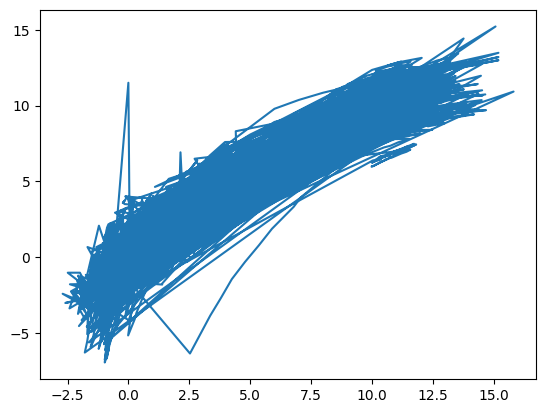

In [6]:
plt.plot(ds.y_train_valid, clf_linreg.predict(ds.TPX_train_valid_scaled))

#### Support Vector Machine regression

Train a SVR model with the best hyperparameters

In [7]:
clf_svr = SVR(kernel = 'rbf', C=298, epsilon=0.000219)
clf_svr.fit(ds.TPX_train_valid_scaled, ds.y_train_valid)

/home/charles/miniconda3/envs/gpflow/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=298, epsilon=0.000219)

Observe the scores

In [8]:
evaluate_model(ds, clf_svr, model_name = "SVR REGRESSION")

SVR REGRESSION
Root Mean Square Errors: 
 Train-Valid    0.38 
 Test     0.50 
Coefficient of Determination: 
 Train-Valid    0.994 
 Test     0.989


# Artificial neural network

The architecture of the ANN was tuned by hand. The default learning rate already allows obtaining reasonable results with minimal overfitting, such that we did not search to tune it further.

In [9]:
# train a neural network
clf_nn = MLPRegressor(solver='adam', alpha=1e-3, hidden_layer_sizes=(20,200),
                    random_state=1, activation='relu', max_iter=10000
                   )

clf_nn.fit(ds.TPX_train_valid_scaled, ds.y_train_valid)

/home/charles/miniconda3/envs/gpflow/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(alpha=0.001, hidden_layer_sizes=(20, 200), max_iter=10000,
             random_state=1)

In [10]:
evaluate_model(ds, clf_nn, model_name = "ANN REGRESSION")

ANN REGRESSION
Root Mean Square Errors: 
 Train-Valid    0.27 
 Test     0.41 
Coefficient of Determination: 
 Train-Valid    0.997 
 Test     0.993


# Random Forest

In [11]:
clf_rf = RandomForestRegressor(
    n_estimators = 149,
    max_depth = 20,
    min_samples_split = 2,
    min_samples_leaf = 1).fit(ds.TPX_train_valid_scaled, ds.y_train_valid)

/home/charles/miniconda3/envs/gpflow/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [12]:
evaluate_model(ds, clf_rf, model_name = "Random Forest REGRESSOR")

Random Forest REGRESSOR
Root Mean Square Errors: 
 Train-Valid    0.11 
 Test     0.45 
Coefficient of Determination: 
 Train-Valid    0.999 
 Test     0.991


## Save models

In [ ]:
joblib.dump(clf_linreg,'./models/clf_linreg.joblib')
joblib.dump(clf_svr,'./models/clf_svr.joblib')
joblib.dump(clf_nn,'./models/clf_nn.joblib')
joblib.dump(clf_rf,'./models/clf_rf.joblib')